# Expected outcome
    - Be able to understand the process of data exploration, cleaning, preprocessing for a regression task
    - Understand and/or revise relevant concepts like : Coefficient of correlation, outliers, standard scaling
    - Understand the process of modelling, evaluating, hyperparams tuning a regression model (not to build a very good model for regression)
    - Sneak peak into decision tree regressor which we will cover in the next session

# Import libraries

In [2]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, f_classif, chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv', header=0)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Exploratory Data Analysis

## Visualize the geographical information

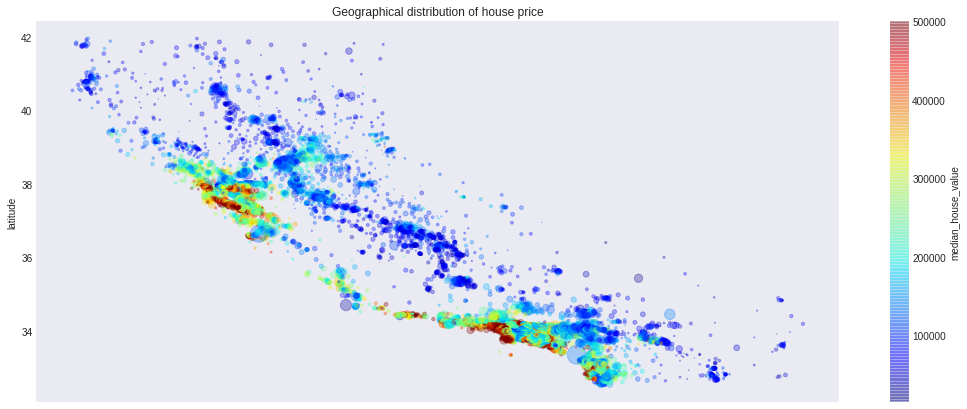

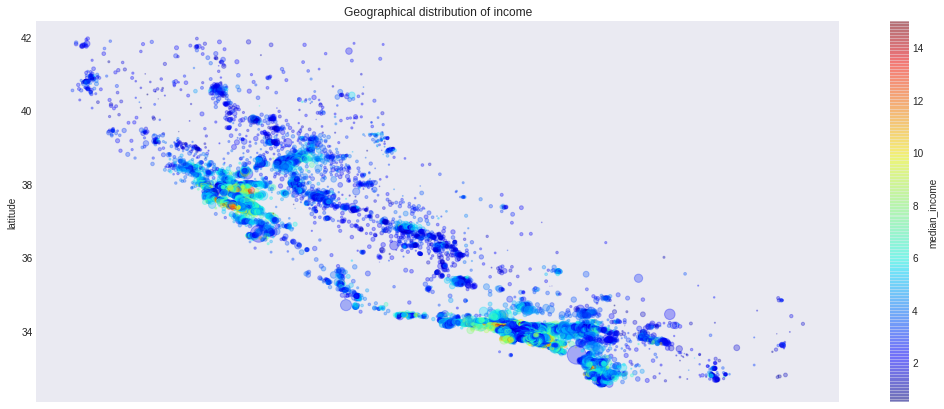

In [4]:
# 1. Visualize only the plain scatter plot of longitude and latitude
# 2. Add alpha to display some opacity
# 3. Add scatter size to display population information
# 4. Add color to display information about house price (For now it is only a gray boring color map)
# 5. Add color map (cmap=plt.get_cmap('jet'))
# 6. Adjust figure size
plt.style.use('seaborn-dark')
data.plot(kind='scatter', x='longitude', y='latitude', 
             alpha = 0.3, s=data['population'] / 100,
             c='median_house_value', cmap=plt.get_cmap('jet'),
             figsize=(18,7), title='Geographical distribution of house price')

# 7. Display another scatter plot with color representing income - show them that 
# The income and the house price correlates a lot based on the geographical information -> transition to correlation
data.plot(kind='scatter', x='longitude', y='latitude', 
             alpha = 0.3, s=data['population'] / 100,
             c='median_income', cmap=plt.get_cmap('jet'),
             figsize=(18,7), title='Geographical distribution of income')
plt.show()

## Visualize the correlation of attributes

In [5]:
# 1. Show people how well correlated income and house price is
def calc_corr(data, col_1, col_2):
    values_1 = data[col_1].values
    values_2 = data[col_2].values
    
    corr = np.corrcoef(values_1, values_2)
    return corr[0, 1] # Show them why we have [0, 1]

# Compute the corr between median house price and income
corr = calc_corr(data, 'median_house_value', 'median_income')
print(f'Correlation between house value and income is {corr}')

# 2. Delete above
# Make column names variables can calc more corr between other columns 
# -> show them how tedious that process is
col_1 = 'median_house_value'
col_2 = 'housing_median_age'
corr = calc_corr(data, col_1, col_2)
print(f'Correlation between {col_1} and {col_2} is {corr}')

Correlation between house value and income is 0.688075207958548
Correlation between median_house_value and housing_median_age is 0.10562341249320994


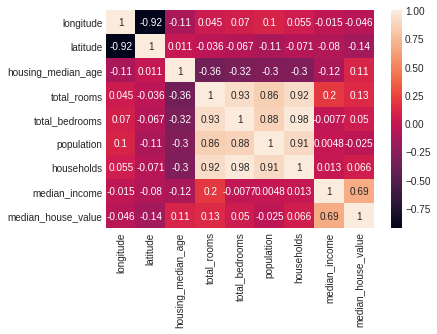

In [6]:
# Cannot calculate all of the corr one by one? Fret not, we have correlation matrix!!
# 1. Show them a plain matrix without annotation
# 2. Add annotation
corr_matrix = data.corr() # Simple AF
sns.heatmap(corr_matrix, annot=True)
plt.show()

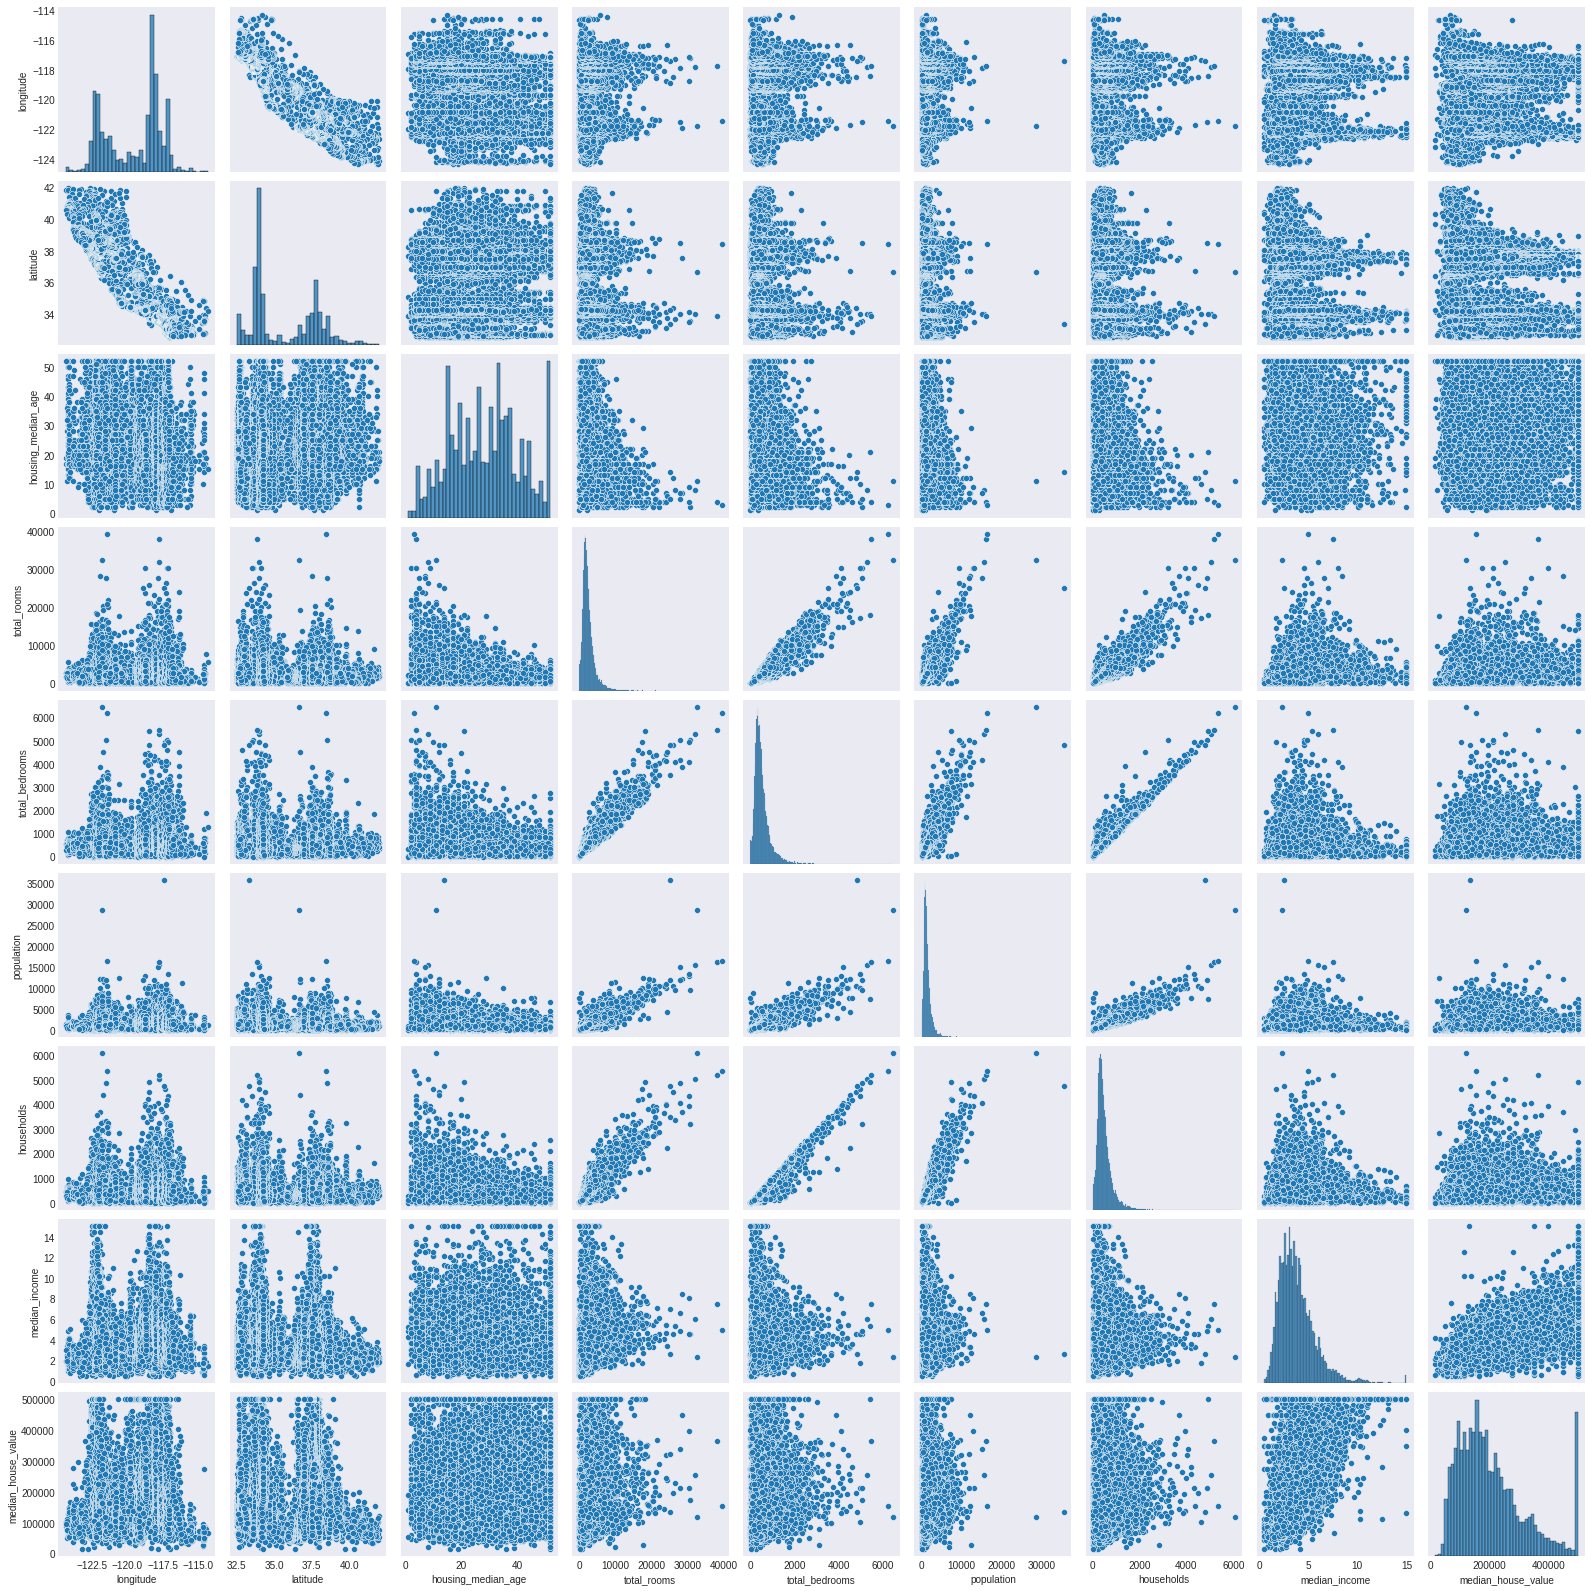

In [7]:
# A more powerful tools : Scatter matrix - shows both the corr and the distribution of features
#pd.plotting.scatter_matrix(data, figsize=(15, 15))
sns.pairplot(data=data)
plt.show()

# I. Data cleaning and feature preprocessing

## Data cleaning
    * Handling missing data
    * Handling non-numeric data
    * Handling outliers

### 1. Handling missing data

In [8]:
# Display the information of the schema first
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# Missing data - Fret not, simpleimuter saving the day
# 1. Create the imputer, explain where u got that class SimpleImputer
imputer = SimpleImputer(strategy='median') # Other strats : mean, most_frequent, constant (fill_value=...)

# 2. Convert the column values into vector form. Explain abit on vector form
# [1,2,3,4,5] -> [[1], [2], ..., [5]]
values = data['total_bedrooms'].values.reshape(-1, 1)

# 3. Use the imputer to replace imputed values into the dataframe
data['total_bedrooms'] = imputer.fit_transform(values)

In [9]:
# 4. Check the data info again to see if there are missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### 2. Handling non-numeric values

In [10]:
# Explain abit on types of categorical data : 
    # 1. Ordinal : categorical data that display a certain sense of order (low, medium, high)
    # 2. Label : No specific order
# So in ordinal data types u may have to display abit of caution in encoding it
# In ocean_proximity column, no such order exists so can just use OrdinalEncoder

# 1. Create the encoder - explain where I get this class
encoder = OrdinalEncoder()

# 2. Convert column to vector form
values = data['ocean_proximity'].values.reshape(-1, 1)

# 3. Use the encoder to process and replace
data['ocean_proximity'] = encoder.fit_transform(values)

In [11]:
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0


### 3. Handling outliers

<AxesSubplot:>

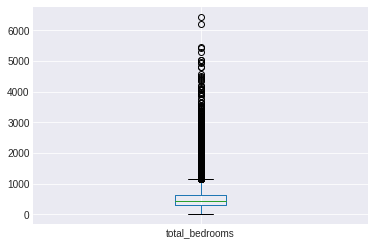

In [12]:
# We are gonna use the simplest of the simplest methods - median replacement
# Other methods : quantile-based flooring and capping, trimming, IQR score, log transformation, ...

# Detect outlier using box plots (show several columns)
data.boxplot(column='total_bedrooms')

In [13]:
# Create a function that checks for outliers in a column
def handle_outliers(data, col):
    # 1. Get the median of the column
    median = data[col].median()
    print(col, median)
    
    # 2. Compute the 75th and 25th quantile
    Q3 = data[col].quantile(.75)
    Q1 = data[col].quantile(.25)
    
    # 3. Compute the IQR
    IQR = Q3 - Q1

    # 4. Compute the lower and upper bound
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # 5. Replace those < Q1 - 1.5*IQR or > Q3 + 1.5*IQR
    # Or condition in pandas : |, And condition in pandas : &
    data[col][(data[col] < lower) | (data[col] > upper)] = median
    
    return data

# Now loop thru all the columns that I want to preprocess 
# Explain that I will exclude 2 columns : median_house_value - because it is the target.
# ocean_proximity - because it is originally a non-numeric column which is encoded to numeric
excluded = ['median_house_value', 'ocean_proximity']
for col in data.columns:
    if(col not in excluded):
        data = handle_outliers(data, col)

data.head(3)

longitude -118.49
latitude 34.26
housing_median_age 29.0
total_rooms 2127.0
total_bedrooms 435.0
population 1166.0
households 409.0
median_income 3.5347999999999997


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,3.5348,452600.0,3.0
1,-122.22,37.86,21.0,2127.0,1106.0,2401.0,409.0,3.5348,358500.0,3.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3.0


<AxesSubplot:>

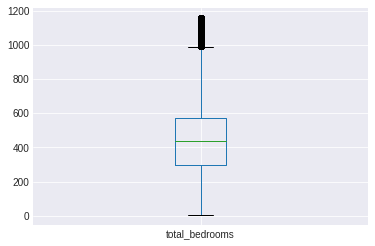

In [14]:
# Not so skewed anymore
# You will still see a bit of outliers because when we replace the outliers with the median
# the overall median of the distribution changes as well. But that's okay. Our purpose is just
# to make the distribution less skewed
data.boxplot(column='total_bedrooms')

## Feature scaling

In [15]:
# Explain why we need feature scaling : You can see that in those numeric values, they have different scales 
# (different range of values). So to stablize training and to not disrupt training by differing variances among
# columns. A simple way we can do is scale all columns values into a gaussian with std=1 and mean=0

# We still exclude our target and our categorical column
excluded = ['median_house_value', 'ocean_proximity']

# 1. Create the scaler
scaler = StandardScaler()

# 2. Loop through all columns and rescale them
for col in data.columns:
    if(col not in excluded):
        # 3. Replace the original values with rescaled values (change to vector form)
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
        
data.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-1.327835,1.052548,0.982143,-1.198131,-1.441326,-1.446447,-1.409524,-0.080920,452600.0,3.0
1,-1.322844,1.043185,-0.607019,-0.082322,2.876356,1.890997,-0.091382,-0.080920,358500.0,3.0
2,-1.332827,1.038503,1.856182,-0.672886,-1.171747,-1.167122,-1.171979,2.462104,352100.0,3.0


# II. Regression modelling

In [25]:
# 1. Get all the columns except for the target column
feature_cols = list(data.columns)
feature_cols.remove('median_house_value')

# 2. Seprate features and columns into two dataframes
features = data[feature_cols]
targets = data['median_house_value']

# 3. Separate dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=1/3)

## 1. Naive approach - Ordinary Least Squares

#### OLS visualization

[INFO] Output visualization gif has been written to regression_viz.gif
[INFO] Visualizing regression model completed!
[INFO] Visualization took 8.288545608520508


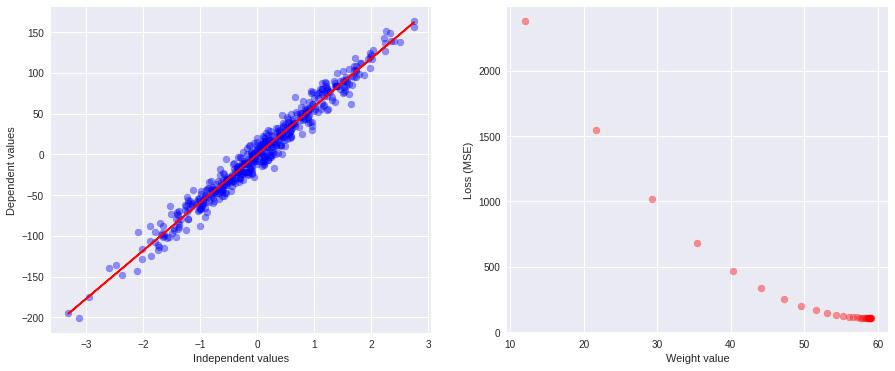

In [26]:
### OLS model visualization ###
from utils import visualize_linear_reg

start = time.time()
visualize_linear_reg(model='ridge', alpha=0.0, lr=0.1, iterations = 30)
print(f'[INFO] Visualization took {time.time() - start}')

#### Building an OLS model in scikit-learn

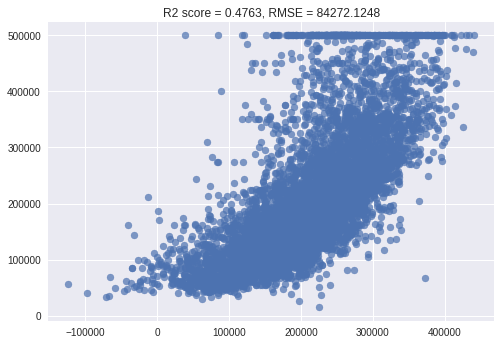

In [27]:
# 1. Build the model 
model = LinearRegression()
model.fit(X_train, Y_train)

# 2. Generate predictions
test_pred = model.predict(X_test)

# 3. Plot the prediction-groundtruth scatter plot
plt.scatter(test_pred, Y_test, alpha=0.7)

# 4. Calculate metrics for evaluating a regression model - R2 and RMSE
# Explain R2 score and RMSE 
# R2 : The square of the correlation between predicted values and ground truth values
    # R2 describes how well prediction fits with the observed data
    # In statistics it is also interpreted as the percentage of variance in the dependent variables (Y)
    # that the independent variable explains (X)
# RMSE : MSE is the sum of squared of errors between predictions and ground truth, RMSE = sqrt(MSE)
r2 = r2_score(Y_test, test_pred)
rmse = np.sqrt(mean_squared_error(Y_test, test_pred))

plt.title(f'R2 score = {r2:.4f}, RMSE = {rmse:.4f}')
plt.show()

## 2. Less naive approach - decision trees
    * This approach will be explained in further details in the next session

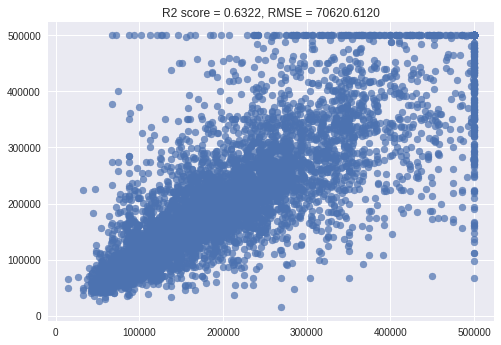

In [30]:
# 1. Build the model 
model = DecisionTreeRegressor()
model.fit(X_train, Y_train)

# 2. Generate predictions
test_pred = model.predict(X_test)

# 3. Plot the prediction-groundtruth scatter plot
plt.scatter(test_pred, Y_test, alpha=0.7)

# 4. Calculate metrics for evaluating a regression model - R2 and RMSE
r2 = r2_score(Y_test, test_pred)
rmse = np.sqrt(mean_squared_error(Y_test, test_pred))

plt.title(f'R2 score = {r2:.4f}, RMSE = {rmse:.4f}')
plt.show()

# Conclusion
    * This is not a complete pipeline to perform a machine learning task (specifically regression task). This is just a slight overview of how regression models are built and some of the metrics of to evaluate a model. Things that haven't been covered in this session : Cross validation, hyperparameters tuning. In the next session we will talk mostly about decision tree and ensembling methods for performing decision trees.